We have implemented a mean-reverting strategy where the number of units we invest in a stationary porfolio is proportional to the deviation of the market value of the unit porfolio from a moving average. It is good because it's parameterless without data-snooping error. However, the strategy is not practical in real-time trading as we will never know beforehand what the maximum capital deployed will be, as there is no limit to the temporary deviation of price from its mean. Therefore, for practical trading, we can use the Bollinger band, where we enter into a position only when the price deviates by more than specified standard deviations from the mean, and exit when price mean-reverts to some standard deviation from the mean.
That is how E.P Chan explains the difference between practical trading and accounts for why we use Bollinger band, in my opnion, the difference is that:
1. Even if we used statistical test to confirm the conintegrity of the assets, however, we cannot guarantee this property remains in the future.
2. For in-sample backtest, lookback is computed by a global optimal parameter, the coefficient of linear regression. But we cannot get it for the period we are trading in.

Also about why we use Bollinger band: I think this serves as a "margin of safety". Because of all the uncertain elements in real-time trading we have compared to a backtest. We will not enter every little bit of deviation, as it might be lookback-biased. So we only trade when the deviation is significant enough so that even if we misestimate the true mean, we are not losing.

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
#get all the data needed
ETF_df = pd.read_csv("GLD_USO.csv", header=None, names=['GLD', 'USO'])
GLD = ETF_df[['GLD']]
USO = ETF_df[['USO']]

In [62]:
from sklearn.linear_model import LinearRegression
lookback = 20 # we pick a arbitrarily short lookback period
hedgeRatio = np.zeros(shape=(GLD.shape[0],1))
# use a dynamically changing hedge ratio based on past period
for t in range(lookback-1, GLD.shape[0]):
    linearModel = LinearRegression()
    linearModel.fit(GLD[t+1-lookback:t+1], USO[t+1-lookback:t+1])
    hedgeRatio[t] = linearModel.coef_[0,0]

In [63]:
y2 = np.concatenate((GLD.values,USO.values),axis=1)
hedgeRatio = -hedgeRatio
hedgeRatio = np.concatenate((hedgeRatio, np.ones((y2.shape[0],1))),axis=1) # construct matrix of coefficients for both prices
yport = np.sum(np.multiply(y2, hedgeRatio), axis=1)
#delete data for first lookback period as we don't have transaction during this time
hedgeRatio = hedgeRatio[lookback:]
yport = yport[lookback:]
y2 = y2[lookback:]

The entry z score for a given period in fact can be optimized in training set, so is the length of lookback period. Here, for simplicity, we just assume it is 1, and exit z score is 0 (when the price reverts to mean). About the detail of implementation, we set the number of units of the unit porfolio to be on if we have a long singal on that day, set it to zero when there is a exit singal, and vice versa for the number of units in short side. For those days we have none of the singals, we carry on the previous day's position.

In [86]:
entryZscore = 1
exitZscore = 0

MA = pd.DataFrame(yport).rolling(lookback).mean()
MSTD = pd.DataFrame(yport).rolling(lookback).std()
zScore = (yport.reshape(yport.shape[0],1)-MA)/MSTD


longsEntry = zScore < -entryZscore
longsExit = zScore > -exitZscore

shortsEntry = zScore > entryZscore
shortsExit = zScore < exitZscore

numUnitsLong = np.full((yport.shape[0], 1), np.nan)
numUnitsShort = np.full((yport.shape[0], 1), np.nan)

#mark long singals
numUnitsLong[0] = 0
numUnitsLong[longsEntry] = 1
numUnitsLong[longsExit] = 0
numUnitsLongDF = pd.DataFrame(numUnitsLong)
numUnitsLongDF.fillna(method='ffill', inplace=True) #fill days with previous position when there are none of singals
numUnitsLong = numUnitsLongDF.values
#mark short singals
numUnitsShort[0] = 0
numUnitsShort[shortsEntry] = -1
numUnitsShort[shortsExit] = 0
numUnitsShortDF = pd.DataFrame(numUnitsShort)
numUnitsShortDF.fillna(method="ffill", inplace=True) #fill days with previous position when there are none of singals
numUnitsShort = numUnitsShortDF.values

C:\Users\a9039\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


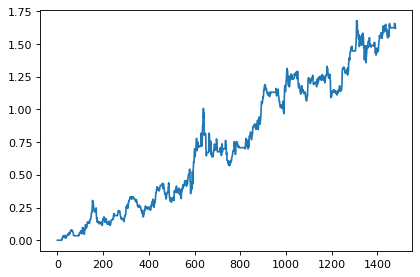

APR= 0.17824927743129648 
Sharpe Ratio= 0.964998956288064


In [87]:
numUnits = numUnitsLong + numUnitsShort
positions = np.repeat(numUnits, y2.shape[1], axis=1)*hedgeRatio*y2 # positions is the dollar capital allocation in each ETF
laggedPosition = pd.DataFrame(positions).shift().values
laggedy2 = pd.DataFrame(y2).shift().values
pnl = np.sum(laggedPosition*(y2-laggedy2)/laggedy2, axis=1) #(y2-laggedy2)/laggedy2 is daily return rate
ret = pnl / np.sum(abs(laggedPosition), axis=1)
ret[np.isnan(ret)] = 0
cumProfit = np.cumprod(1+ret)-1 #calculate cumulative profit
fig=plt.figure(figsize=(6, 4), dpi= 80, facecolor='w', edgecolor='k') #plot the result
plt.plot(cumProfit)
plt.show()
APR = np.power(np.prod(1+ret),252/ret.size)-1
SharpeRatio = np.sqrt(252)*np.mean(ret)/np.std(ret)
print("APR=",APR,"\nSharpe Ratio=",SharpeRatio)

Some notes:
1. We do not really need to wait until the price reverts to the mean, but we can set any exit point lower than entry point. An advantage of being that flexible is that even if the price is not actually mean-reverting, we can still profit from it by constantly realizing small profits.
2. Using multiple entries and exits will never be optimal. We can always find a single entry/exit level that generates a higher average return in backtest.